# **1. 데이터 차원**
- 불균형 데이터에 대한 처리 부분 추가  
  -> **가중 무작위 샘플링(Weighted Random Sampling)** 활용
- Albumentation 적용

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - lr scheduling
    - 초기 lr: 1e-5
    - min_lr: 1e-12
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss --- 가중치 적용
- 배치/ Epoch
    - 충분한 학습이 이루어질 수 있도록 Epoch 수 증가
    - batch size: 128
    - Epoch: 200

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 

1.12.1+cu116


### **Random Sampling**

In [3]:
### 가중치 함수

def make_weights(df,classes):
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        weight = 1 / count    
        weights = [weight] * count    # 라벨이 뽑힐 가중치를 count의 역수로 동일하게 전체 라벨에 할당 
        weight_list += weights
 
    return weight_list

In [4]:
### 데이터 가져오기
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

In [5]:
### 가중치 생성
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
weights = make_weights(train_data_df,feelings_list)
# print(weights)

### **DataLoader**

In [6]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [8]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [9]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [10]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,shuffle = True, drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False, drop_last = False)
    
    return dataloaders

In [11]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [12]:
from torchsummary import summary

In [13]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [14]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    batch_size = image.shape[0] 
    prediction = model(image).to(device) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [15]:
### Epoch을 1번 수행

def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}  # loss값 저장
    accuracies = {} # 정확도 계산
    
    for tv in ["train", "val"]: 
        ### loss, accuracy 갱신
        running_loss = 0.0 
        running_correct = 0.0
        
        if tv == "train":
            model.train() # 학습
        else:
            model.eval() # 평가
            
            
        for index, batch in enumerate(dataloaders[tv]): 
            image = batch['image'].to(device) # feature data(이미지)
            label = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'):
                prediction = model(image) # label 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # gradient를 0으로 초기화
                    loss.backward() # 역전파 적용
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
            
            ### 학습 과정 monitoring
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        ### loss, accuracy 저장            
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
        
    return losses, accuracies

In [16]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [17]:
### 가중 손실 함수

def get_class_weights(df,classes):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    cnt_lists = [] # 각 클래스의 데이터 수 저장
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        cnt_lists.append(count)
    
    weights = [1-(x / sum(cnt_lists)) for x in cnt_lists]
    class_weights = torch.cuda.FloatTensor(weights).to(device) # 가중치 설정
    
    return class_weights


### 가중치 생성
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_weights = get_class_weights(train_data_df,feelings_list)
# print(class_weights)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model().to(device)
loss_func = nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean').to(device) # 가중 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-12,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
num_epochs = 200

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    # LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/227 - Running loss: 1.959006428718567
30/227 - Running loss: 1.8964594602584839
60/227 - Running loss: 1.8833075761795044
90/227 - Running loss: 1.7468500137329102
120/227 - Running loss: 1.7761313915252686
150/227 - Running loss: 1.7795946598052979
180/227 - Running loss: 1.7965400218963623
210/227 - Running loss: 1.7402291297912598
1/200-Train Loss:1.8041591250423819, Val Loss:1.7174026472815151
1/200-Train Acc:0.3637802863436123, Val Acc:0.43681509351256576
0/227 - Running loss: 1.6991122961044312
30/227 - Running loss: 1.7375435829162598
60/227 - Running loss: 1.7219874858856201
90/227 - Running loss: 1.7505125999450684
120/227 - Running loss: 1.6475681066513062
150/227 - Running loss: 1.6993646621704102
180/227 - Running loss: 1.691491961479187
210/227 - Running loss: 1.7411854267120361
2/200-Train Loss:1.7141207734918804, Val Loss:1.675368387123634
2/200-Train Acc:0.46014592511013214, Val Acc:0.4800052966101695
0/227 - Running loss: 1.6656111478805542
30/227 - Running loss: 1.6

180/227 - Running loss: 1.5687021017074585
210/227 - Running loss: 1.5871210098266602
18/200-Train Loss:1.5381372106232831, Val Loss:1.5735763434706063
18/200-Train Acc:0.6434127202643172, Val Acc:0.5911290911747515
0/227 - Running loss: 1.5744506120681763
30/227 - Running loss: 1.5199034214019775
60/227 - Running loss: 1.4869699478149414
90/227 - Running loss: 1.5231181383132935
120/227 - Running loss: 1.579769492149353
150/227 - Running loss: 1.4682331085205078
180/227 - Running loss: 1.539418339729309
210/227 - Running loss: 1.5799140930175781
EarlyStopping counter: 1 out of 10
19/200-Train Loss:1.5324280046681475, Val Loss:1.5746573168655922
19/200-Train Acc:0.6487472466960352, Val Acc:0.5831841759205143
0/227 - Running loss: 1.5256829261779785
30/227 - Running loss: 1.517663598060608
60/227 - Running loss: 1.5184831619262695
90/227 - Running loss: 1.606527328491211
120/227 - Running loss: 1.565441608428955
150/227 - Running loss: 1.5061782598495483
180/227 - Running loss: 1.544054

210/227 - Running loss: 1.4998669624328613
EarlyStopping counter: 2 out of 10
35/200-Train Loss:1.4657852612928146, Val Loss:1.556774694344093
35/200-Train Acc:0.7160999449339207, Val Acc:0.6039733708357685
0/227 - Running loss: 1.4594241380691528
30/227 - Running loss: 1.487916350364685
60/227 - Running loss: 1.460046648979187
90/227 - Running loss: 1.5072429180145264
120/227 - Running loss: 1.472267746925354
150/227 - Running loss: 1.5265182256698608
180/227 - Running loss: 1.501639723777771
210/227 - Running loss: 1.4667404890060425
EarlyStopping counter: 3 out of 10
36/200-Train Loss:1.4647076865124808, Val Loss:1.5511574457431663
36/200-Train Acc:0.7184746696035242, Val Acc:0.6094069623027469
0/227 - Running loss: 1.4418094158172607
30/227 - Running loss: 1.360711693763733
60/227 - Running loss: 1.4360644817352295
90/227 - Running loss: 1.508394718170166
120/227 - Running loss: 1.5005255937576294
150/227 - Running loss: 1.4965581893920898
180/227 - Running loss: 1.4182987213134766

60/227 - Running loss: 1.4554483890533447
90/227 - Running loss: 1.3870997428894043
120/227 - Running loss: 1.3997429609298706
150/227 - Running loss: 1.3729500770568848
180/227 - Running loss: 1.4385278224945068
210/227 - Running loss: 1.3975847959518433
EarlyStopping counter: 2 out of 10
52/200-Train Loss:1.416708457837546, Val Loss:1.5407865335201394
52/200-Train Acc:0.7592579845814978, Val Acc:0.6195983708357685
0/227 - Running loss: 1.4274405241012573
30/227 - Running loss: 1.4558664560317993
60/227 - Running loss: 1.390110969543457
90/227 - Running loss: 1.382312536239624
120/227 - Running loss: 1.39881432056427
150/227 - Running loss: 1.4023888111114502
180/227 - Running loss: 1.3790509700775146
210/227 - Running loss: 1.419526219367981
EarlyStopping counter: 3 out of 10
53/200-Train Loss:1.4142983274837948, Val Loss:1.5405663786263302
53/200-Train Acc:0.7603593061674009, Val Acc:0.6206759570426651
0/227 - Running loss: 1.4185752868652344
30/227 - Running loss: 1.426688671112060

150/227 - Running loss: 1.404335379600525
180/227 - Running loss: 1.437939167022705
210/227 - Running loss: 1.392144799232483
EarlyStopping counter: 10 out of 10
Bset Accuracy: 0.6237763004091176


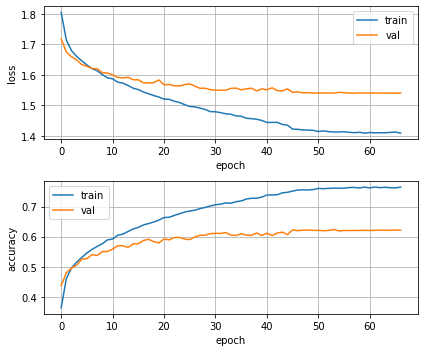

In [20]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()